In [15]:
import os
import sys
sys.path.append('/fefs/aswg/workspace/mitsunari.takahashi/Soft/common')

from LowLevelAnalysis import ConfigItem, ImageExtractorConfig, TailcutConfig, LowLevelAnalysis
from LowLevelData import Data, DL0Data, DL0DataSingleFile, DL1Data, DL1DataSingleFile

import pickle
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import math

from math import ceil
import numpy as np
import numpy.ma as ma
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import tables
from collections import OrderedDict

import astropy.units as u
from astropy.io import fits
from astropy.table import Table, vstack
import datetime

from traitlets.config.loader import Config
from ctapipe_io_lst import LSTEventSource
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.image import hillas_parameters
from ctapipe.containers import EventType

from lstchain.io.config import read_configuration_file
import lstchain.reco.utils as utils
from lstchain.reco import r0_to_dl1
from lstchain.io.io import dl1_images_lstcam_key, dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_lstcam_key, dl1_params_src_dep_lstcam_key

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource
from ctapipe.io.eventseeker import EventSeeker
#import astropy.units as u
#from copy import deepcopy

from scipy.stats import binned_statistic

import pSLUM

In [2]:
from logging import getLogger,StreamHandler,DEBUG,INFO,WARNING,ERROR,CRITICAL

##### Logger #####
logger = getLogger(__name__)
handler = StreamHandler()
loglevel = 'INFO'
handler.setLevel(loglevel)
logger.setLevel(loglevel)
logger.addHandler(handler)

In [3]:
from lstchain import __version__ as lstchain_version
logger.info(lstchain_version)
#lstchain_version = lstchain_version.rsplit('.',maxsplit=1)[0]
#logger.info(lstchain_version)

0.8.5.dev6+g50b0a41.d20220128


In [4]:
# Matplotlib setup
plt.rcParams["font.size"] = 13

LINE_STYLES = ["solid", "dashed", "dashdot", "dotted"]
MARKER_STYLES = ['o', 's', 'x', '+', 'D', 'X', 'p', 'd', '<', '>', '^', 'v', 'H']

#plt.xkcd()

In [5]:
# Replace OUTPUT_DIR_PATH by your directory
OUTPUT_DIR_PATH = Path('/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses')
if not OUTPUT_DIR_PATH.exists():
    os.makedirs(OUTPUT_DIR_PATH)

In [6]:
EMIN = 0 *u.GeV
EMAX = 100 *u.GeV

In [7]:
tel_id = 1 #LST-1
allowed_tels = {tel_id}

In [8]:
REQUSTED_PARAMETERS = ["event_type",
                       'intensity', 
                       'log_intensity', 
                       'length', 
                       'width', 
                       'wl', 
                       'skewness',
                       'kurtosis', 
                       'leakage_intensity_width_2', 
                       'n_islands',
                       'intercept',
                       'n_pixels',
                       'time_gradient',
                       'concentration_cog', 
                       'concentration_core',
                       'concentration_pixel']

In [9]:
HILLASES_OF_INTEREST = ['intensity', 
                        'log_intensity', 
                        'length', 
                        'width', 
                        'wl', 
                        'skewness',
                        'kurtosis', 
                        'leakage_intensity_width_2', 
                        'n_islands',
                        'n_pixels',
                        'time_gradient',
                        'concentration_cog', 
                        'concentration_core',
                        'concentration_pixel']

# Real data

In [10]:
real_runs = [3948, 4699, 4859, 2969, 3094, 3954] #4066] #2181, 4859]
real_dates = {3948: '20210310', 4699: '20210511', 2181: '20200710', 4859: '20210531',
              2969: '20201120', 3094: '20201207', 4066: '20210315', 3954: '20210311'}
real_subruns = {3948: range(50, 51), 4699: range(50, 51), 2181: range(50, 51), 4859: range(50, 51), 
                2969: range(50, 51), 3094: range(50, 51), 4066: range(50, 51), 3954: range(50, 51)}
calibration_runs = {3948:3945, 4699: 4696, 2181: 2175, 4859: 4851, 
                    2969: 2964, 3094: 3092, 4066: 4076, 3954: 3963}
drs4_pedestal_runs = {3948: 3944, 4699: 4695, 2181: 2174, 4859: 4850, 
                      2969: 2963, 3094: 3091, 4066: 4065, 3954:3958}
#time_calibration_runs = {3948: 3945, 4699: 4696, 2181: 2175, 4859: 4851}
time_calibration_runs = {3948: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',
                         4699: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20210321/v0.8.0/time_calibration.Run04211.0000.h5',
                         2181: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',
                         4859: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20210321/v0.8.0/time_calibration.Run04211.0000.h5',
                         2969: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',
                         3094: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',                         
                         4066: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',
                         3954: '/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/drs4_time_sampling_from_FF/20191124/v0.8.0/time_calibration.Run01625.0000.h5',                         
                         }
#enf_sys_dates = {3948: '20210321', 4699: '20210403', 2181: '20200725', 4859: '20210514'}
analysis_version = {3948: 'v0.7.1', 4699: 'v0.7.3', 2181: 'v0.7.3', 4859: 'v0.7.3',
                    2969: 'v0.8.3', 3094: 'v0.8.3', 4066: 'v0.7.1', 3954: 'v0.7.1'}
source_runs = {3948: 'DP', 4699: 'DP', 2181: 'DP', 4859: 'DP',
               2969: 'Crab', 3094: 'Crab', 4066: 'Crab', 3954: 'Crab'}
zenith_runs = {3948: 'Low', 4699: 'Low', 2181: 'Low', 4859: 'Low',
               2969: 'Low', 3094: 'Low', 4066: 'Low', 3954: 'Low'}

# Real DL1 data

In [13]:
out_dir_path = OUTPUT_DIR_PATH / 'official'
if not out_dir_path.is_dir():
    os.makedirs(out_dir_path)
    
real_dl1_data_dict = {}
subrun_dl1_path_dict = {}
dl1_pickle_path_dict = {}
for run in real_runs:
    subrun_data_list = []
    subrun_dl1_path_dict[run] = {}
    dl1_pickle_path_dict[run] = str(out_dir_path/'DL1RealData_Run{run:0>5.0f}.pickle'.format(run=run))
    command = ['srun', 'python', '/home/mitsunari.takahashi/Work/Soft/cta-analysis/lst-pulselevel/Read_DL1files.py',
               str(run), '--datasrc', 'Real', '--emin', str(EMIN.to_value(u.GeV)), '--emax', str(EMAX.to_value(u.GeV)), '--tel', str(tel_id), 
               '--picklepath', dl1_pickle_path_dict[run],
               '--loglevel', 'INFO']    
    for param in REQUSTED_PARAMETERS:
        command.append('-p')
        command.append(param)
        
    for subrun in real_subruns[run]:
        subrun_dl1_path_dict[run][subrun] = Path('/fefs/aswg/data/real/DL1/{date}/{anaver}/{tail}/dl1_LST-{tel}.Run{run:0>5.0f}.{subrun:0>4.0f}.h5'\
        .format(date=real_dates[run], anaver=analysis_version[run], tail='tailcut84', tel=tel_id, run=run, subrun=subrun))
        if subrun_dl1_path_dict[run][subrun].is_file(): 
            logger.info('{0} exists.'.format(subrun_dl1_path_dict[run][subrun]))
                #continue
        else:             
            logger.error('{0} has NOT been produced!!'.format(subrun_dl1_path_dict[run][subrun]))
            break
        command.append('-s')
        command.append(str(subrun_dl1_path_dict[run][subrun]))
    logger.debug(' '.join(command))
    subprocess.run(command)

    
          

/fefs/aswg/data/real/DL1/20210310/v0.7.1/tailcut84/dl1_LST-1.Run03948.0050.h5 exists.
/fefs/aswg/data/real/DL1/20210310/v0.7.1/tailcut84/dl1_LST-1.Run03948.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x2b8a915d5fd0>]...
Closing remaining open files:/fefs/aswg/data/real/DL1/20210310/v0.7.1/tailcut84/dl1_LST-1.Run03948.0050.h5...done
/fefs/aswg/data/real/DL1/20210511/v0.7.3/tailcut84/dl1_LST-1.Run04699.0050.h5 exists.
/fefs/aswg/data/real/DL1/20210511/v0.7.3/tailcut84/dl1_LST-1.Run04699.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x2b8f3c158f40>]...
Closing remaining open files:/fefs/aswg/data/real/DL1/20210511/v0.7.3/tailcut84/dl1_LST-1.Run04699.0050.h5...done
/fefs/aswg/data/real/DL1/20210531/v0.7.3/tailcut84/dl1_LST-1.Run04859.0050.h5 exists.
/fefs/aswg/data/real/DL1/20210531/v0.7.3/tailcut84/dl1_LST-1.Run04859.0050.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x2b47aca95940>]...
Closing remaining open files:/fefs/aswg/data/r

In [19]:
for k, run in enumerate(real_runs):
    logger.info(dl1_pickle_path_dict[run])
    with open(dl1_pickle_path_dict[run], 'rb') as pfile:
        dl1_data = pickle.load(pfile)
        logger.warning('Data {dname}'.format(dname=dl1_data.name))        
        interleaved_pedestal = np.array(dl1_data.parameter_value_dict["event_type"])==EventType.SKY_PEDESTAL.value
        survived_pedestal = (np.array(dl1_data.parameter_value_dict["event_type"])==EventType.SKY_PEDESTAL.value) * (np.array(dl1_data.parameter_value_dict["intensity"])>0)
        logger.warning('    {n} pedestal events survived.'.format(n=sum(survived_pedestal))) 
        logger.info('    Survived fraction: {pf:3.3f}%'.format(pf=100*sum(survived_pedestal)/sum(interleaved_pedestal)))

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/official/DL1RealData_Run03948.pickle
Data DL1 Real Run 3948
    0 pedestal events survived.
    Survived fraction: 0.000%
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/official/DL1RealData_Run04699.pickle
Data DL1 Real Run 4699
    0 pedestal events survived.
    Survived fraction: 0.000%
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/official/DL1RealData_Run04859.pickle
Data DL1 Real Run 4859
    0 pedestal events survived.
    Survived fraction: 0.000%
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/official/DL1RealData_Run02969.pickle
Data DL1 Real Run 2969
    1 pedestal events survived.
    Survived fraction: 0.107%
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/official/DL1RealData_Run03094.pickle
Data DL1 Real Run 3094
    0 pedestal events survived.
    Survived fraction: 0.000%
/home/mitsunari.takahashi/Work/analysis/low-level/LowLe

# MC DL0 data

In [41]:
N_MCEVENTS = 50

dl0_paths = []
for i in range(1, N_MCEVENTS+1):3
    dl0_paths.append(Path('/fefs/aswg/data/mc/DL0/20200629_prod5_trans_80/proton/zenith_20deg/south_pointing/proton_20deg_180deg_run{r}___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.simtel.gz'.format(r=i)))

#dl0_path = Path('/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/4LSTs_MAGIC/gamma-diffuse/zenith_20deg/south_pointing/run1000/sim_telarray_v3_trans_80%/cta-prod5-lapalma_4LSTs_MAGIC/0.0deg/Data/gamma_20deg_180deg_run1000___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz')
#dl0_path = Path('/fefs/aswg/data/mc/DL0/20200629_prod5/gamma-diffuse/zenith_20deg/south_pointing/gamma_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz')

In [42]:
dl0_data = DL0Data(name='DL0 MC Proton', emin=EMIN, emax=EMAX, tel_id=tel_id)

In [43]:
dl0_datum_list = []
for idatum, dl0_path in enumerate(dl0_paths):
    dl0_datum_list.append(DL0DataSingleFile(name='{0}_{1}'.format(dl0_data.name, idatum), 
                                            file_path=dl0_path, 
                                            emin=EMIN, emax=EMAX, 
                                            tel_id=tel_id))
dl0_data.add_data(datum_list=dl0_datum_list)

37 events has been added.
50 events has been added.
36 events has been added.
39 events has been added.
47 events has been added.
Falling back to gzip module
41 events has been added.
47 events has been added.
43 events has been added.
Falling back to gzip module
39 events has been added.
Falling back to gzip module
50 events has been added.
47 events has been added.
42 events has been added.
Falling back to gzip module
38 events has been added.
Falling back to gzip module
38 events has been added.
Falling back to gzip module
26 events has been added.
Falling back to gzip module
45 events has been added.
Falling back to gzip module
41 events has been added.
Falling back to gzip module
51 events has been added.
Falling back to gzip module
36 events has been added.
Falling back to gzip module
36 events has been added.
Falling back to gzip module
38 events has been added.
Falling back to gzip module
42 events has been added.
Falling back to gzip module
50 events has been added.
Falling ba


# MC DL1 data

In [44]:
dl1_data_dict = {}
for lowlevel_config in lowlevel_configs:
    logger.info(lowlevel_config.name)
    dl1_datum_list = []
    for dl0_datum in dl0_datum_list:
        dl1_datum_list.append(dl0_datum.produce_mc_dl1(lowlevel_config=lowlevel_config, 
                                                       hillas_parameters=REQUSTED_PARAMETERS))
        #print(dl1_datum_list[-1].true_phe)
        #print(len(dl1_datum_list[-1].dl1_image_tables))
        #print(dl1_datum_list[-1].file_path)
    dl1_data_dict[lowlevel_config] = DL1Data(name=dl0_data.name.replace('DL0','DL1').replace('dl0','dl1'),
                                             datasrc=dl0_data.DATASRC,
                                             hillas_parameters=REQUSTED_PARAMETERS,
                                             emin=EMIN, emax=EMAX, tel_id=tel_id)
    dl1_data_dict[lowlevel_config].add_data(datum_list=dl1_datum_list)
    if dl0_data.true_phe.size!=dl1_data_dict[lowlevel_config].dl1_reco_phe.size:
        logger.critical('The pulse number of DL0 ({0}) and that of DL1 ({1}) does not match!!!'\
                        .format(dl0_data.true_phe.size, dl1_data_dict[lowlevel_config].dl1_reco_phe.size))

LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 6 hours 7 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___ct

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 6 hours 55 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 6 hours 54 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 2 hours 44 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 2 hours 44 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window

LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 6 hours 54 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___c

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 6 hours 42 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 6 hours 42 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 25 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 24 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window

LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 6 hours 42 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___c

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 30 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 29 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 4 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 4 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_w

LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 29 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___c

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 17 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 16 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 44 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 1 hours 44 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window

LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 16 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___c

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 3 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 3 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_w

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 0 hours 24 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 0 hours 24 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window

LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 3 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___ct

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 50 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 2 days 5 hours 49 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 0 hours 4 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 0 hours 3 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_w

LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 24 hours 55 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 24 hours 43 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 24 hours 43 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_wind

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 24 hours 31 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_window_width3_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 30 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift1_wind

LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 22 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 10 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 9 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_windo

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 57 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 56 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_wind

LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 47 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 35 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 23 hours 34 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_wind

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run38___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 22 hours 22 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_window_width8_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 22 hours 22 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift4_wind

In [45]:
len(dl1_data_dict[lowlevel_config].dl1_image_tables)

2140

## DL1 Data Readout

In [46]:

#dl1_datum_list = []
#for idatum, dl1_path in enumerate(dl0_paths):
#    dl0_datum_list.append(DL0DataSingleFile(name='{0}_{1}'.format(dl0_data.name, idatum), file_path=dl0_path, emin=EMIN, emax=EMAX, tel_id=tel_id))
#dl0_data.add_data(datum_list=dl0_datum_list)

In [47]:
#for lowlevel_config in lowlevel_configs:
#    lowlevel_config.read_dl1(event_used, tel_id=1, hillas_parameters=HILLASES_OF_INTEREST)#emin=EMIN, emax=EMAX)
#    if len(lowlevel_config.dl1_reco_phe)!=len(true_phe):
#        logger.critical('The pulse number of DL0 and DL1 does not match!!!')

In [48]:
for lowlevel_config in lowlevel_configs:
    dl1_data_dict[lowlevel_config].make_hist_pulselevel()

# Plot

/tmp/ipykernel_13556/1724184096.py:48: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats['std'][0]/np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
/tmp/ipykernel_13556/1724184096.py:54: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[iax][0].set_ylim(-1, 10)
/tmp/ipykernel_13556/1724184096.py:62: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
/tmp/ipykernel_13556/1724184096.py:77: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats['std'][0][1:]/np.sqrt(dl1_data.reco_phe_frac_stats['count'][0][1:]), \
/tmp/ipykernel_13556/1724184096.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
/tmp/ipykernel_13556/1724184096.py:14

/tmp/ipykernel_13556/1724184096.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
/tmp/ipykernel_13556/1724184096.py:147: RuntimeWarning: invalid value encountered in true_divide
  dl1_data.reco_phe_stats['std'][0][1:] / \
/tmp/ipykernel_13556/1724184096.py:48: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats['std'][0]/np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
/tmp/ipykernel_13556/1724184096.py:54: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[iax][0].set_ylim(-1, 10)
/tmp/ipykernel_13556/1724184096.py:62: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
/tmp/ipykernel_13556/1724184096.py:77: RuntimeWarning: invalid value encountered in true_divide
  y

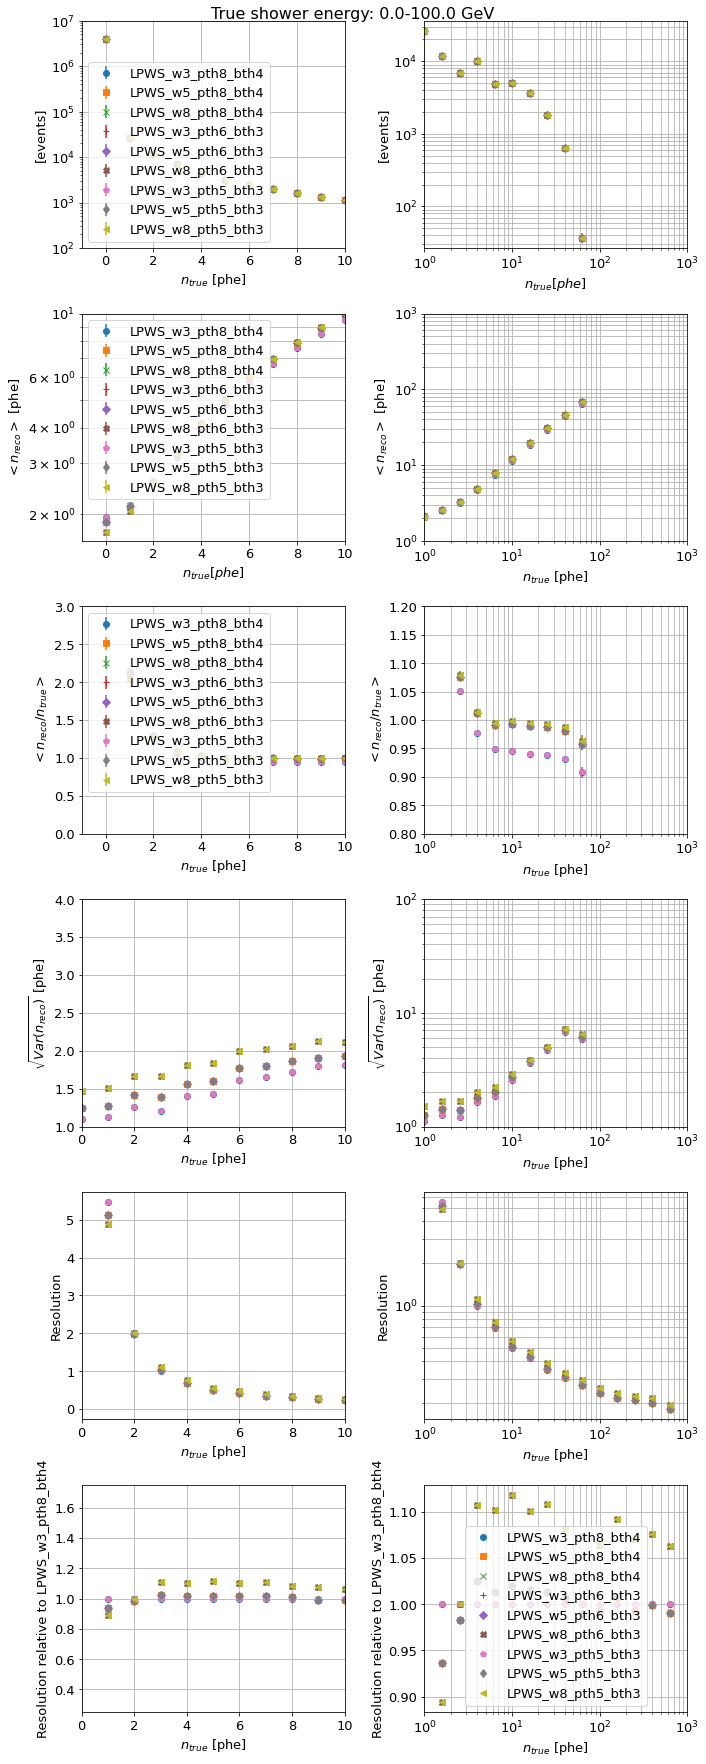

In [49]:
lowlevel_config_benchmark = lowlevel_configs[0]
dl1_data_benchmark = dl1_data_dict[lowlevel_config_benchmark]

fig, axes = plt.subplots(6, 2, figsize=(10, 25))
fig.suptitle('True shower energy: {0:.1f}-{1:.1f} GeV'.format(EMIN.to(u.GeV).value, EMAX.to(u.GeV).value), fontsize=16)
for i, lowlevel_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]
    iax = 0
    
    # Linear X-axis
    xvalues = (dl1_data.reco_phe_stats['mean'][1][:-1])
    
    # Log X-axis    
    logxvalues = (dl1_data.reco_phe_stats_log['mean'][1][:-1])
        
    # Event count 
    axes[iax][0].errorbar(xvalues, \
                          dl1_data.reco_phe_stats['count'][0], \
                          yerr=np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='major', axis='both')
    axes[iax][0].set_yscale('log')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(100, 1e7)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('[events]')
    #axes[iax][0].legend(loc=0)


    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_stats_log['count'][0], \
                          yerr=np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][1].set_ylim(1, 1000)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true} [phe]$')
    axes[iax][1].set_ylabel('[events]')
                         
    iax += 1
        
    axes[iax][0].errorbar(xvalues, \
                          dl1_data.reco_phe_stats['mean'][0], \
                          yerr=dl1_data.reco_phe_stats['std'][0]/np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_yscale('log')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(-1, 10)
    axes[iax][0].set_xlabel(r'$n_{true} [phe]$')
    axes[iax][0].set_ylabel(r'$<n_{reco}>$ [phe]')
    axes[iax][0].legend(loc=0)


    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_stats_log['mean'][0], \
                          yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(1, 1000)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$<n_{reco}>$ [phe]')
                         
    iax += 1

    axes[iax][0].errorbar(xvalues[1:], \
                          dl1_data.reco_phe_frac_stats['mean'][0][1:], \
                          yerr=dl1_data.reco_phe_frac_stats['std'][0][1:]/np.sqrt(dl1_data.reco_phe_frac_stats['count'][0][1:]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(0, 3)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel(r'$<n_{reco}/n_{true}>$')

    # Log X-axis    
    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_frac_stats_log['mean'][0], \
                          yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(0.8, 1.2)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$<n_{reco}/n_{true}>$')
                         
    iax += 1
    
    axes[iax][0].plot(xvalues, \
                    dl1_data.reco_phe_stats['std'][0], MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_ylim(1, 4)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel(r'$\sqrt{Var(n_{reco})}$ [phe]')

    axes[iax][1].plot(logxvalues, \
                    dl1_data.reco_phe_stats_log['std'][0], MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(1, 100)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$\sqrt{Var(n_{reco})}$ [phe]')   
                         
    iax += 1
    axes[iax][0].plot(xvalues[1:], \
                    dl1_data.reco_phe_stats['std'][0][1:] / \
                    (dl1_data.reco_phe_stats['mean'][0][1:]-dl1_data.mean_phe_true0), \
                    MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('Resolution') #(r'$\sqrt{Var(n_{reco})} / (\bar{n}_{reco}-\bar{n}_{reco}(n_{true}=0))$')

    axes[iax][1].plot(logxvalues[1:], \
                    dl1_data.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                    (dl1_data.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data.mean_phe_true0), \
                    MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][0].set_ylim(0, 3)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel('Resolution')#r'$\sqrt{Var(n_{reco})} / (\bar{n}_{reco}-\bar{n}_{reco}(n_{true}=0))$')
    
    iax += 1
    axes[iax][0].plot(xvalues[1:], \
                      dl1_data.reco_phe_stats['std'][0][1:] / \
                      dl1_data_benchmark.reco_phe_stats['std'][0][1:] / \
                      (dl1_data.reco_phe_stats['mean'][0][1:]-dl1_data.mean_phe_true0) * \
                      (dl1_data_benchmark.reco_phe_stats['mean'][0][1:]-dl1_data_benchmark.mean_phe_true0), \
                      MARKER_STYLES[i%len(MARKER_STYLES)], label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_ylim(0.25, 1.75)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('Resolution relative to {0}'.format(lowlevel_config_benchmark.abbreviation))    

    axes[iax][1].plot(logxvalues[1:], \
                      dl1_data.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                      dl1_data_benchmark.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                      (dl1_data.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data.mean_phe_true0) * \
                      (dl1_data_benchmark.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data_benchmark.mean_phe_true0), \
                      MARKER_STYLES[i%len(MARKER_STYLES)], label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    #axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][0].set_ylim(0, 3)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel('Resolution relative to {0}'.format(lowlevel_config_benchmark.abbreviation))
    
axes[0][0].legend(loc=0)   
axes[2][0].legend(loc=0)
axes[5][1].legend(loc=0)
plt.tight_layout()    

## Distribution for specific-phe-number events

In [50]:
list_true_phes = [0, 3, 6, 10] #List of the true photoelectron numbers to draw the distribution of the reconstructed phe
mask_truephe = {}
true_phe_bins = np.linspace(-10, 30, 81)

for i, lowlevel_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]    
    for tphe in list_true_phes:
        mask_truephe[tphe] = np.array(dl1_data.true_phe!=tphe)
        dl1_data.reco_phe_hists[tphe] = np.histogram(dl1_data.dl1_reco_phe, \
                                                     weights=[float(1-m) for m in mask_truephe[tphe]], \
                                                     bins=true_phe_bins)

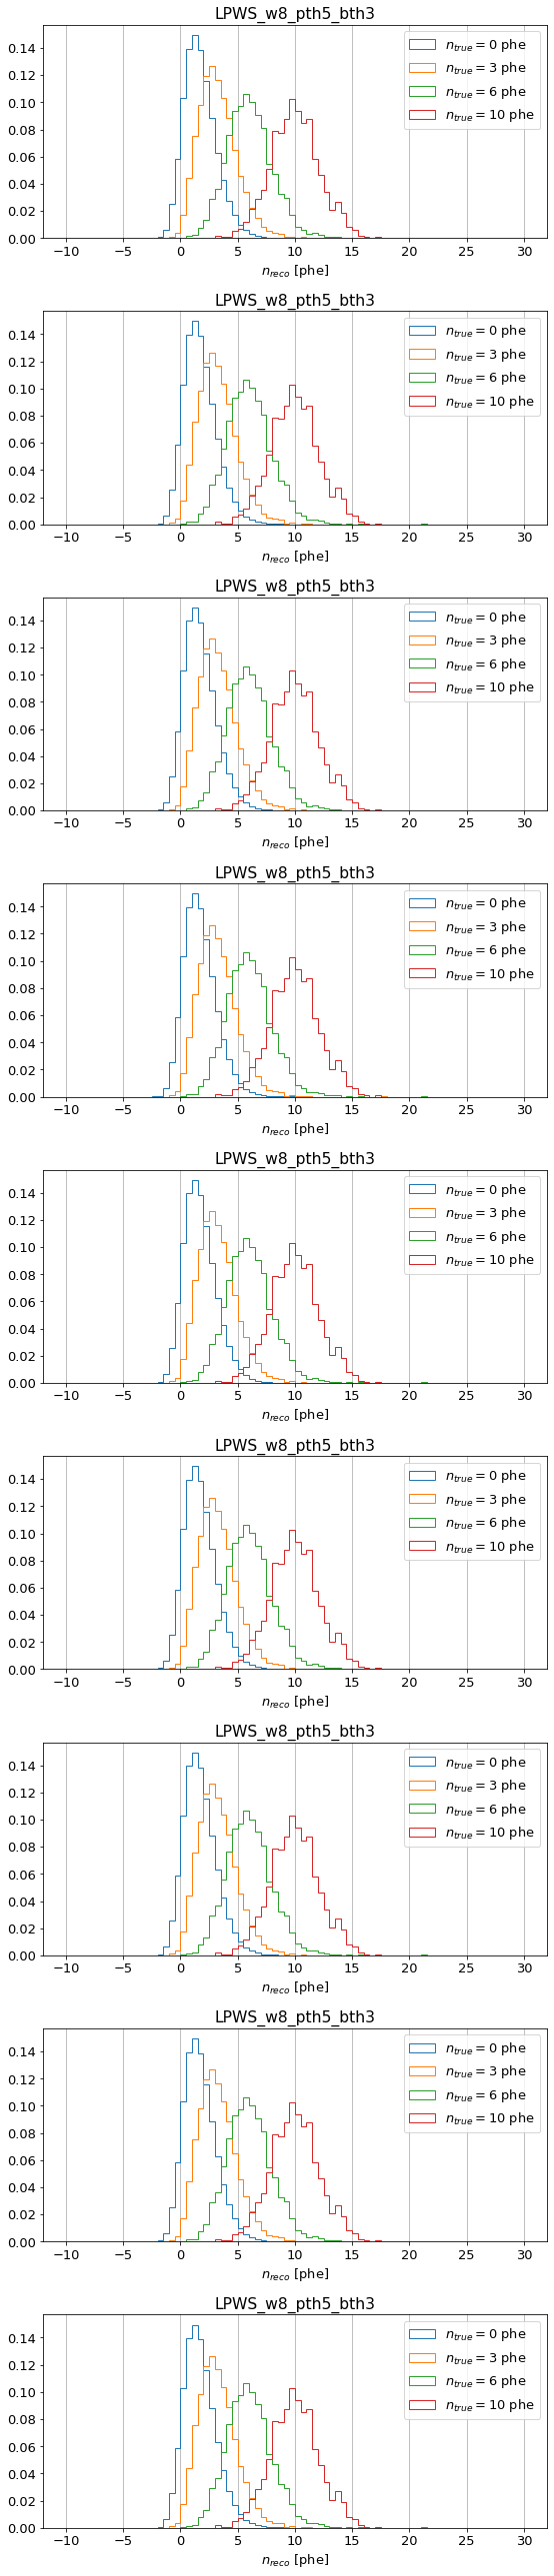

In [51]:
fig, axes = plt.subplots(len(lowlevel_configs), 1, figsize=(8, 4*len(lowlevel_configs)))
for i, image_extracter_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]     
    for j, tphe in enumerate(list_true_phes):
        axes[i].hist(dl1_data.reco_phe_hists[tphe][1][:-1], \
                     dl1_data.reco_phe_hists[tphe][1], \
                     weights=dl1_data.reco_phe_hists[tphe][0]/sum(dl1_data.reco_phe_hists[tphe][0]), \
                     label=r'$n_{{true}}={{{0}}}$ phe'.format(tphe), histtype='step')#, alpha=0.2)
    axes[i].set_title(lowlevel_config.abbreviation)
    axes[i].grid(True, which='major', axis='x')
    axes[i].set_xlabel(r'$n_{reco}$ [phe]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

## ROC Curve

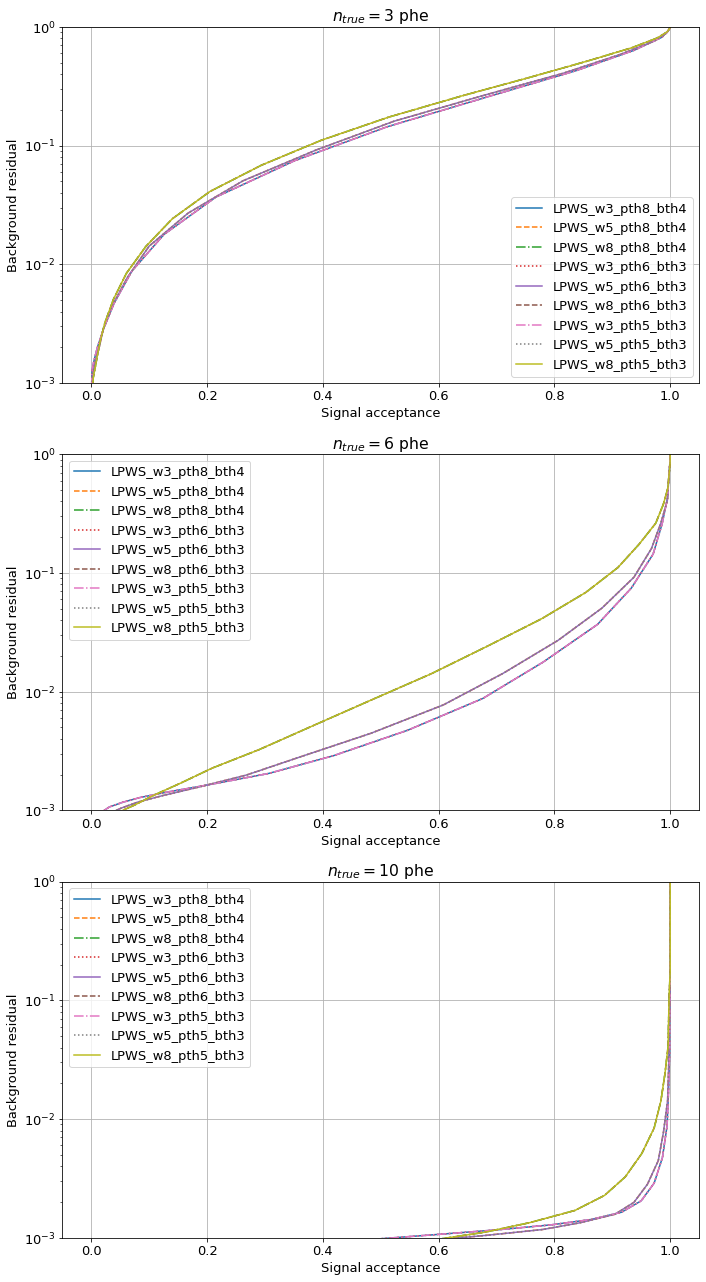

In [52]:

sig_phes = [3, 6, 10]
fig, axes = plt.subplots(len(sig_phes), 1, figsize=(10, 6*len(sig_phes)))

for i, sig_phe in enumerate(sig_phes):
    for j, lowlevel_config in enumerate(lowlevel_configs):
        dl1_data = dl1_data_dict[lowlevel_config] 
        xvals, yvals = dl1_data.get_roc_curve(sig_phe=sig_phe)
        axes[i].plot(xvals, yvals, label=lowlevel_config.abbreviation, ls=LINE_STYLES[j%len(LINE_STYLES)])
    axes[i].set_title(r'$n_{{true}}={0}$ phe'.format(sig_phe))
    axes[i].grid(True, which='major', axis='both')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel('Signal acceptance')
    axes[i].set_ylabel('Background residual')
    axes[i].legend(loc=0)    
plt.tight_layout()  


# Separation power evaluation
Not working well yet

In [53]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,3])

In [54]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,6])

In [55]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,10])

# Hillas Parameters

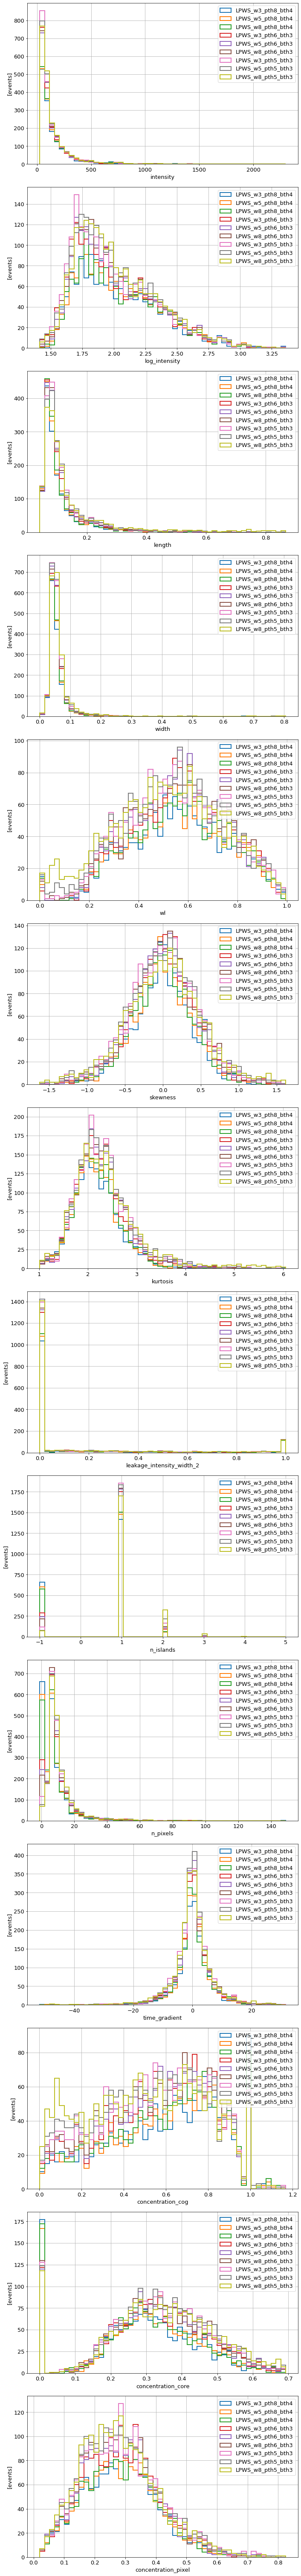

In [56]:
fig, axes = plt.subplots(len(HILLASES_OF_INTEREST), 1, figsize=(10, 6*len(HILLASES_OF_INTEREST)))

for i, param in enumerate(HILLASES_OF_INTEREST):
    for j, lowlevel_config in enumerate(lowlevel_configs):
        dl1_data = dl1_data_dict[lowlevel_config] 
        vals = dl1_data.parameter_value_dict[param]
        if j==0:
            hist_result = axes[i].hist(vals, lw=2, bins=50, histtype="step", label=lowlevel_config.abbreviation)
        else:
            axes[i].hist(vals, lw=2, bins=hist_result[1], histtype="step", label=lowlevel_config.abbreviation)
    #axes[i].set_title(param)
    axes[i].grid(True, which='major', axis='both')
    #axes[i].set_yscale('log')
    #axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('[events]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

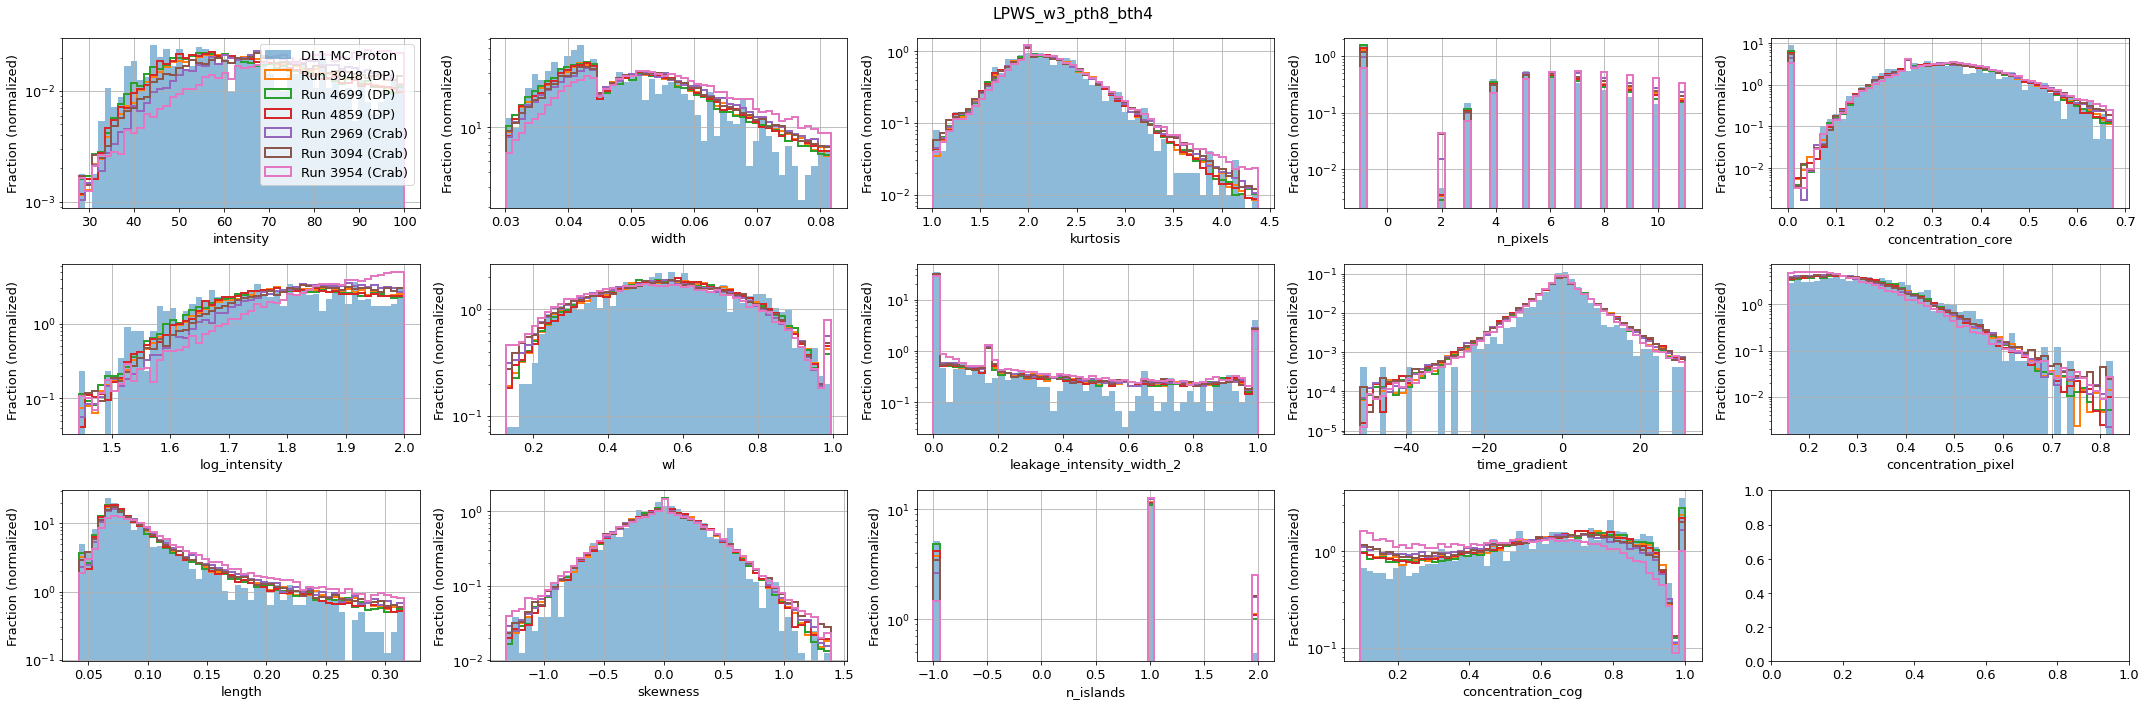

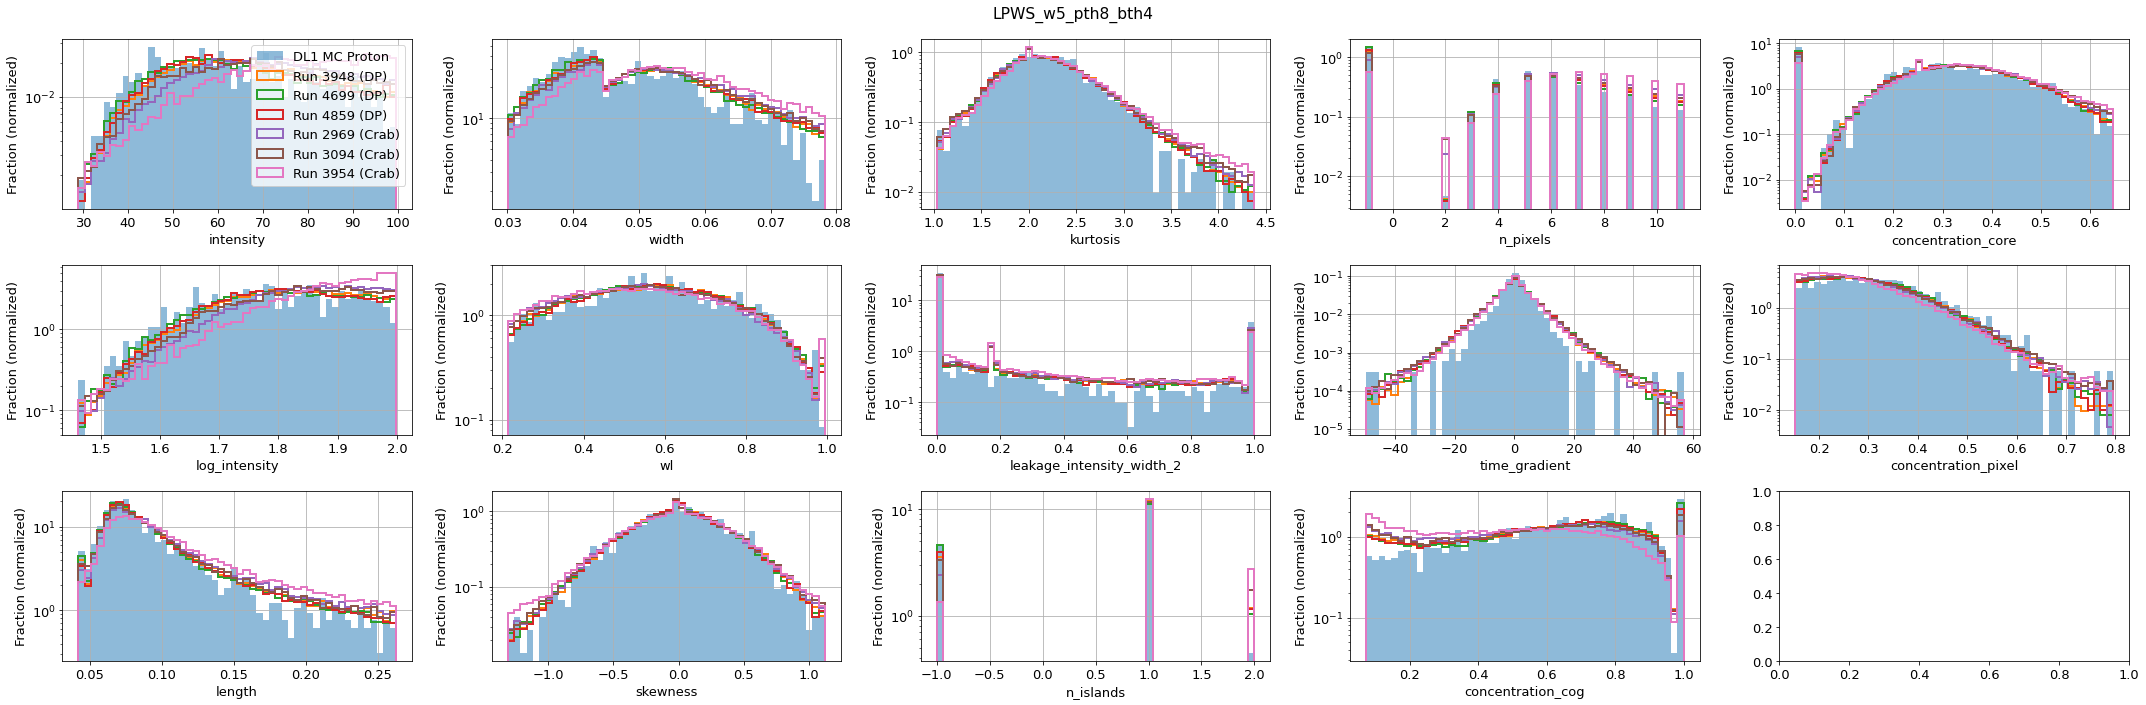

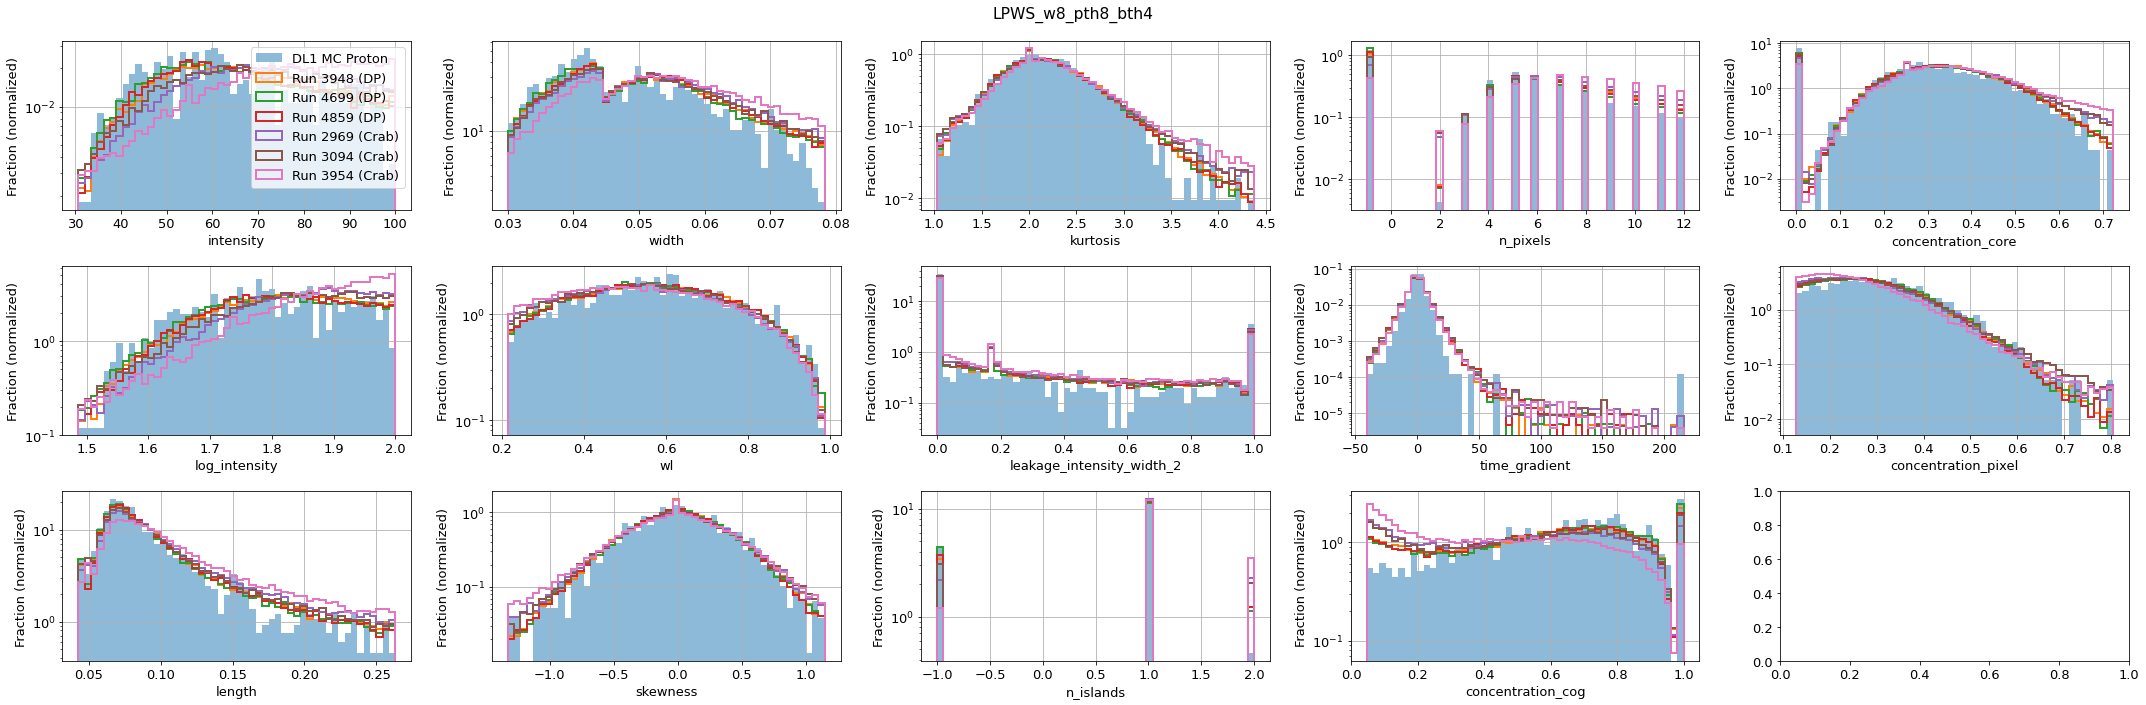

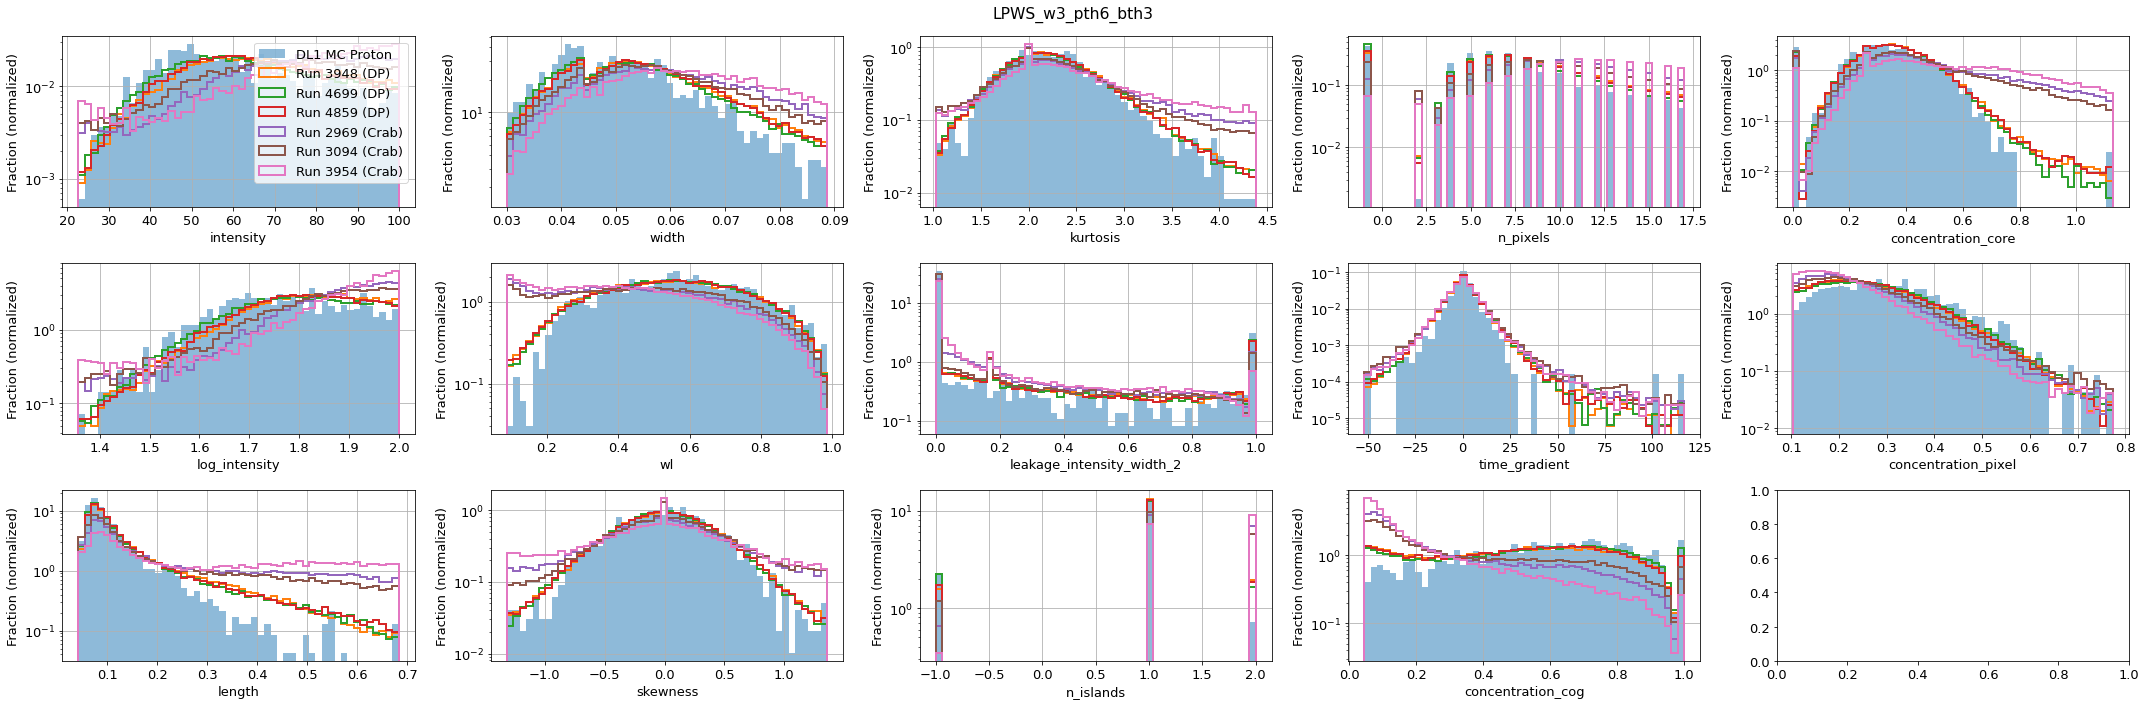

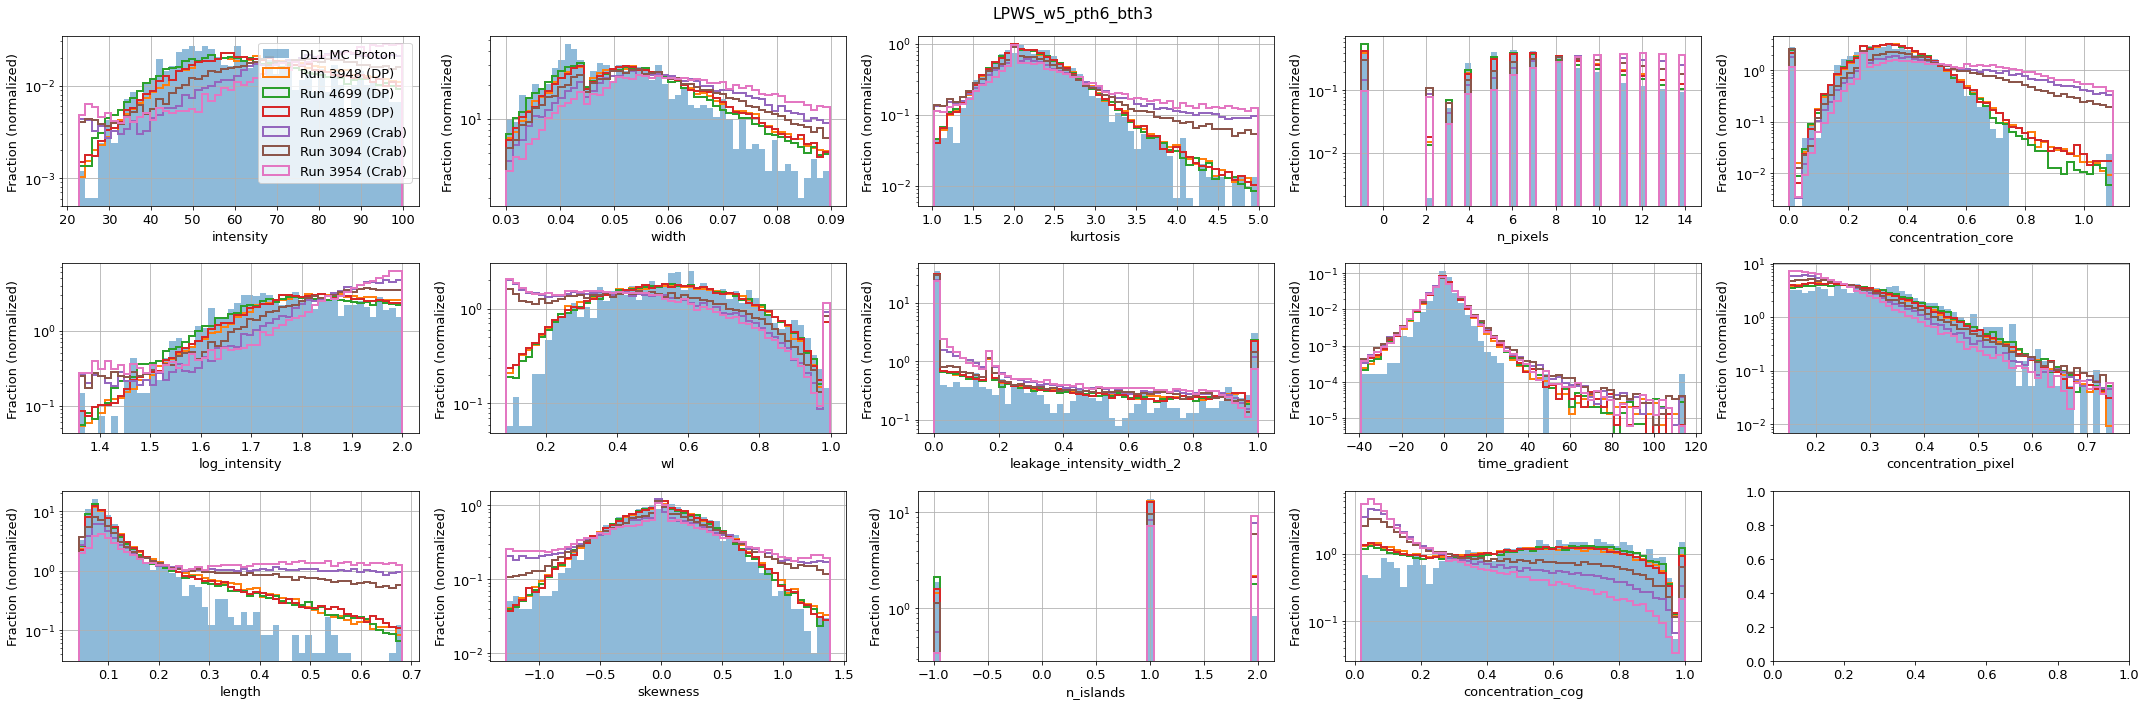

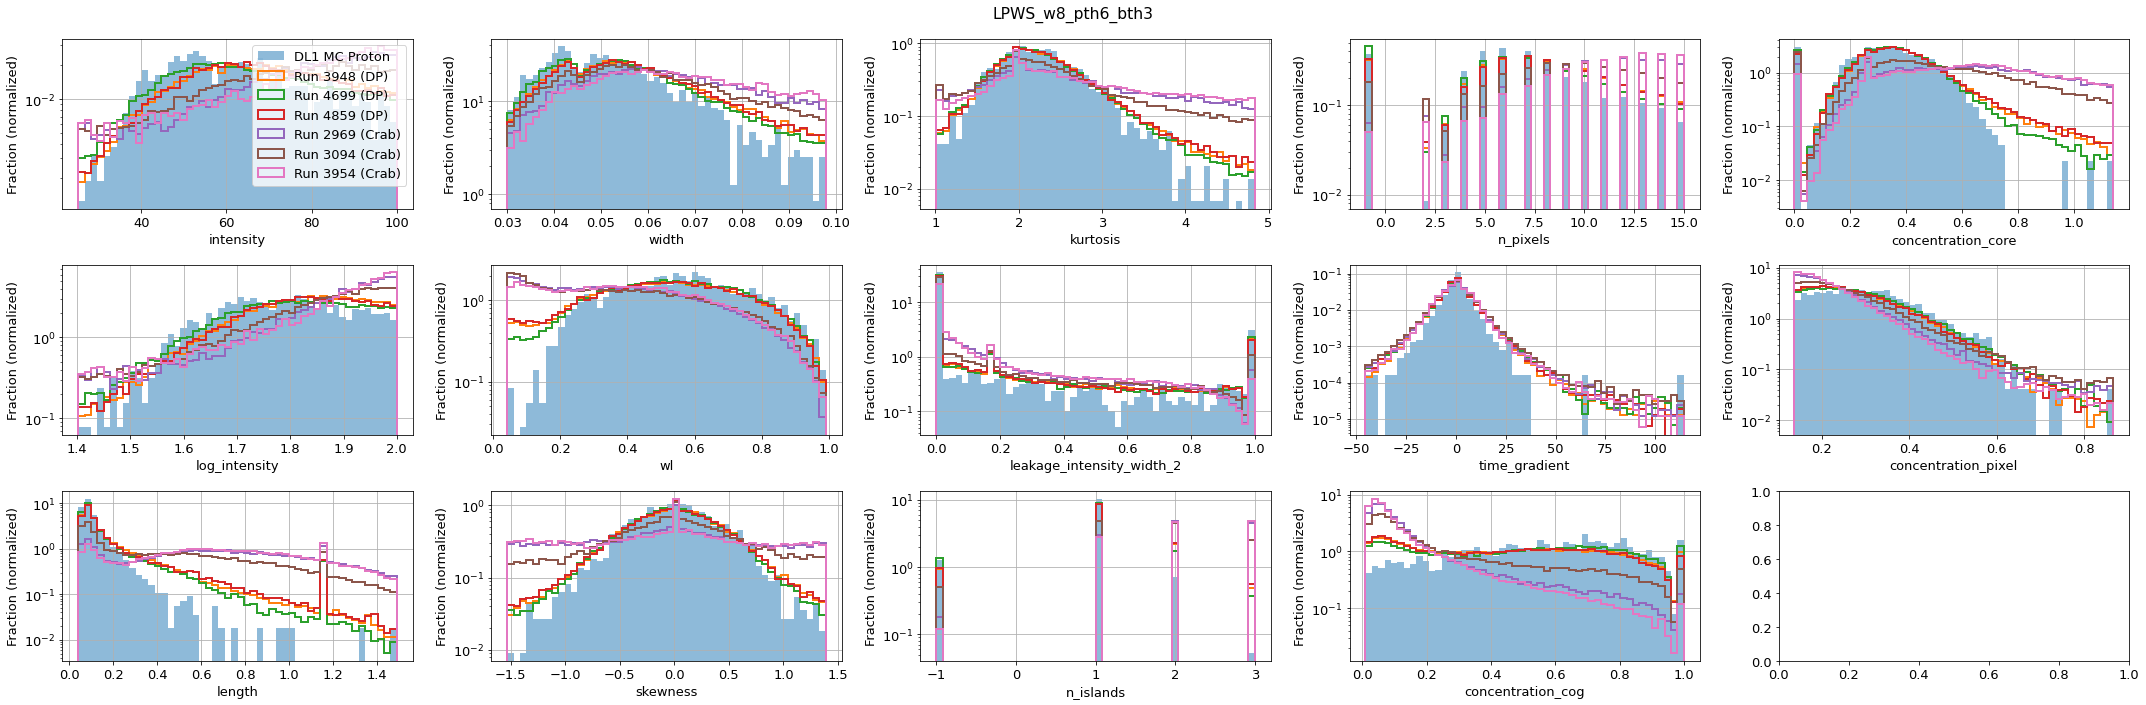

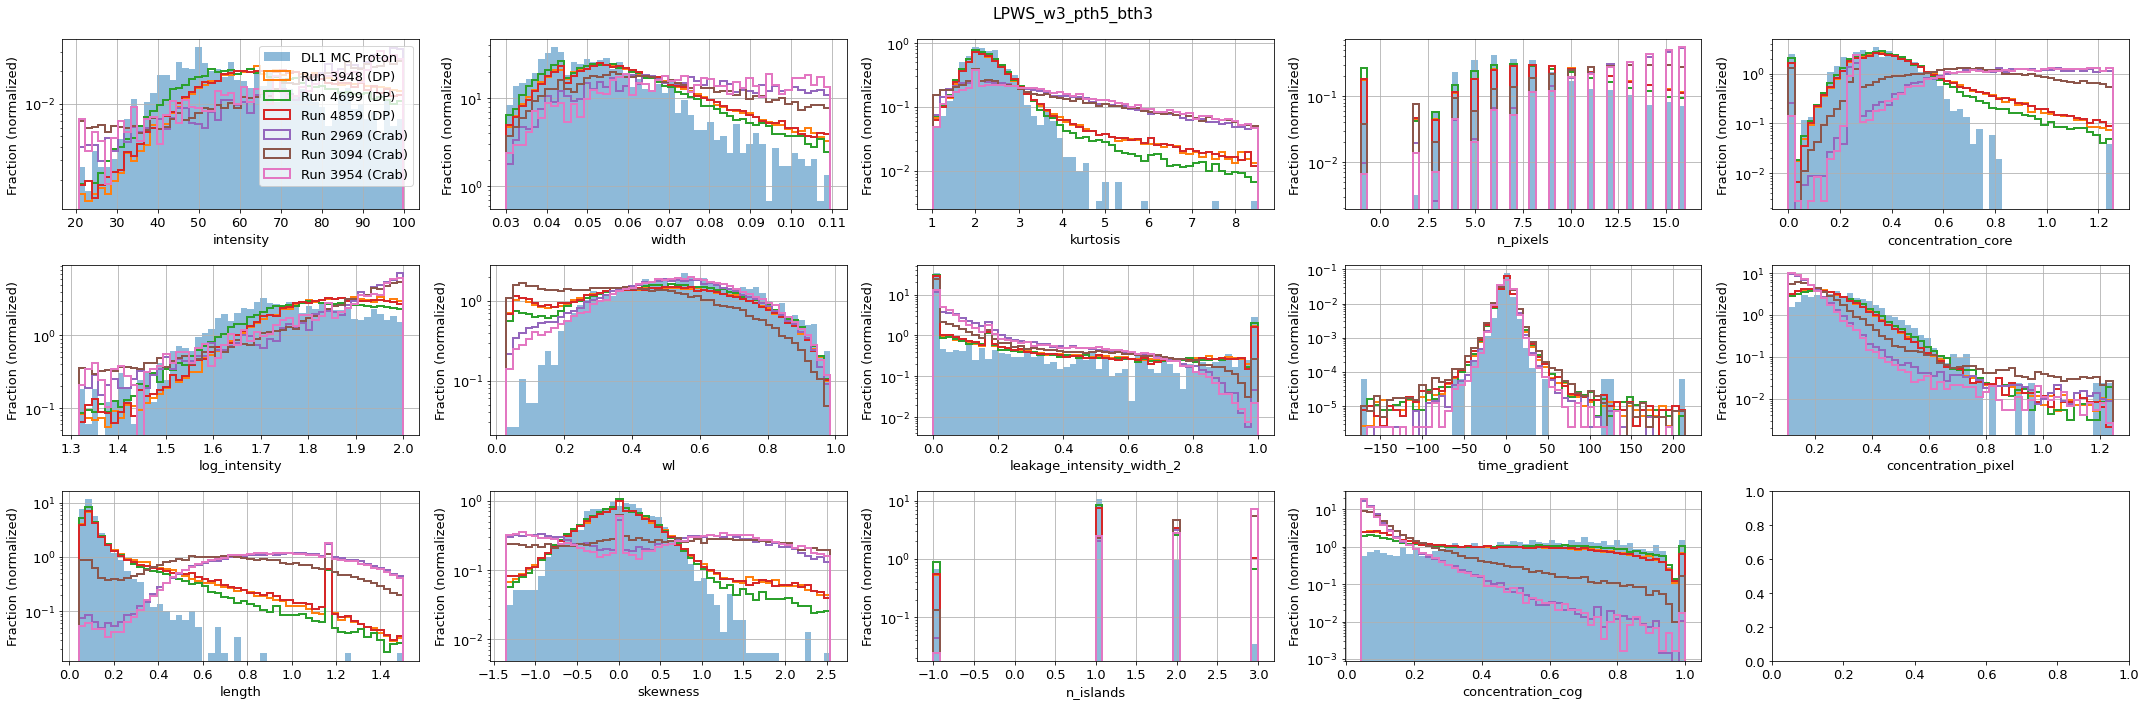

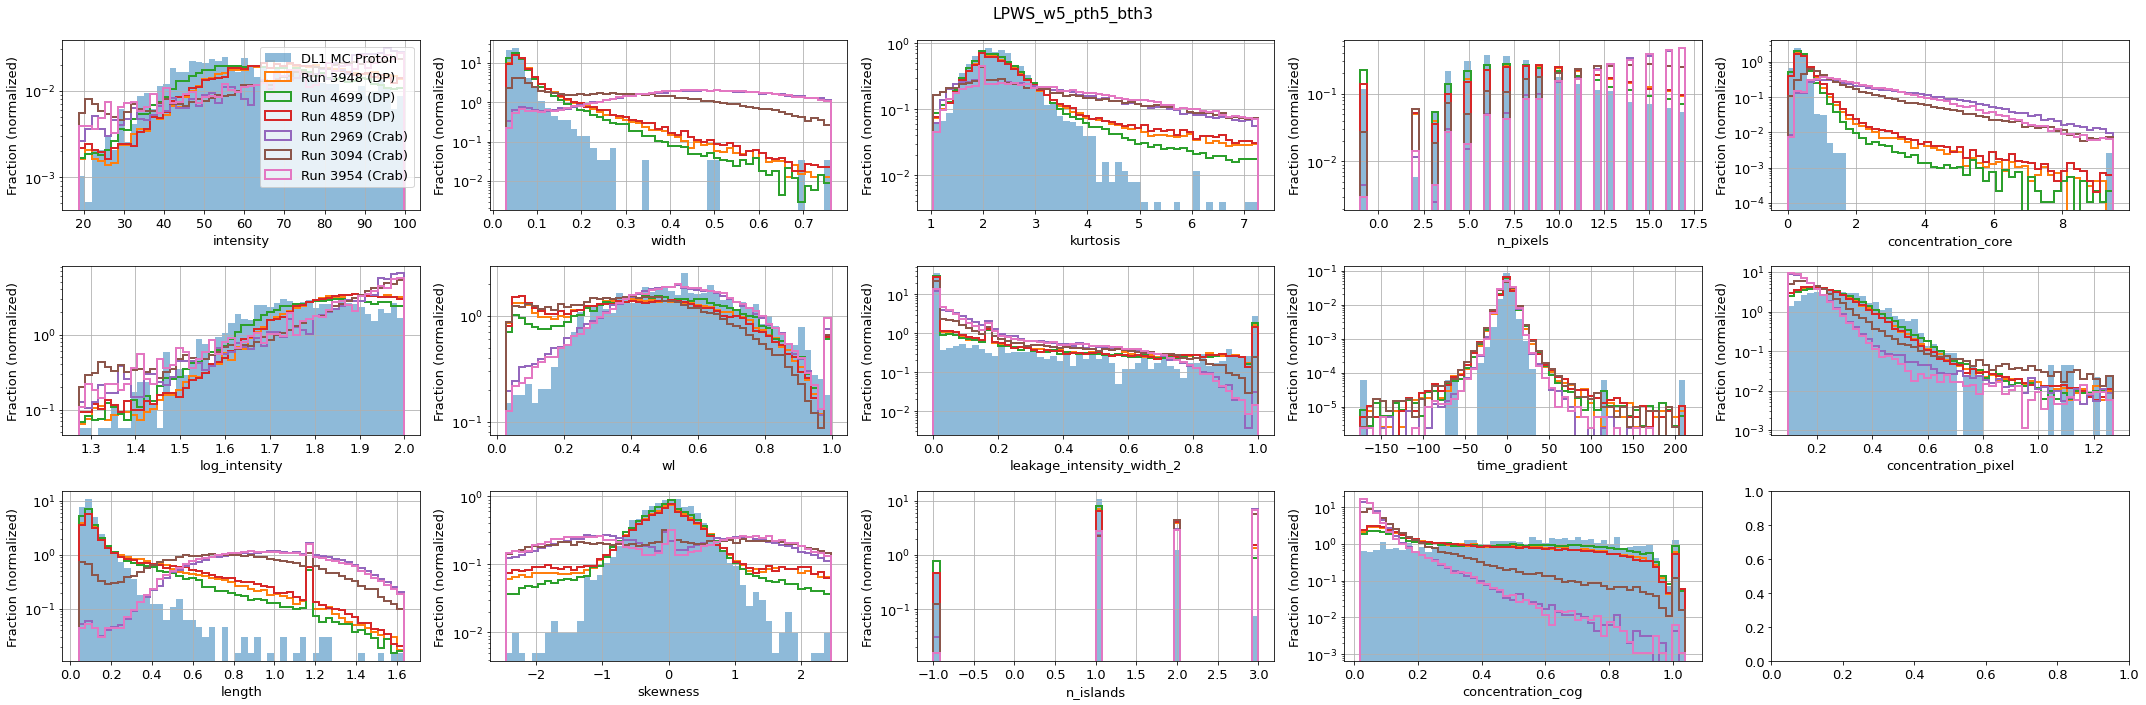

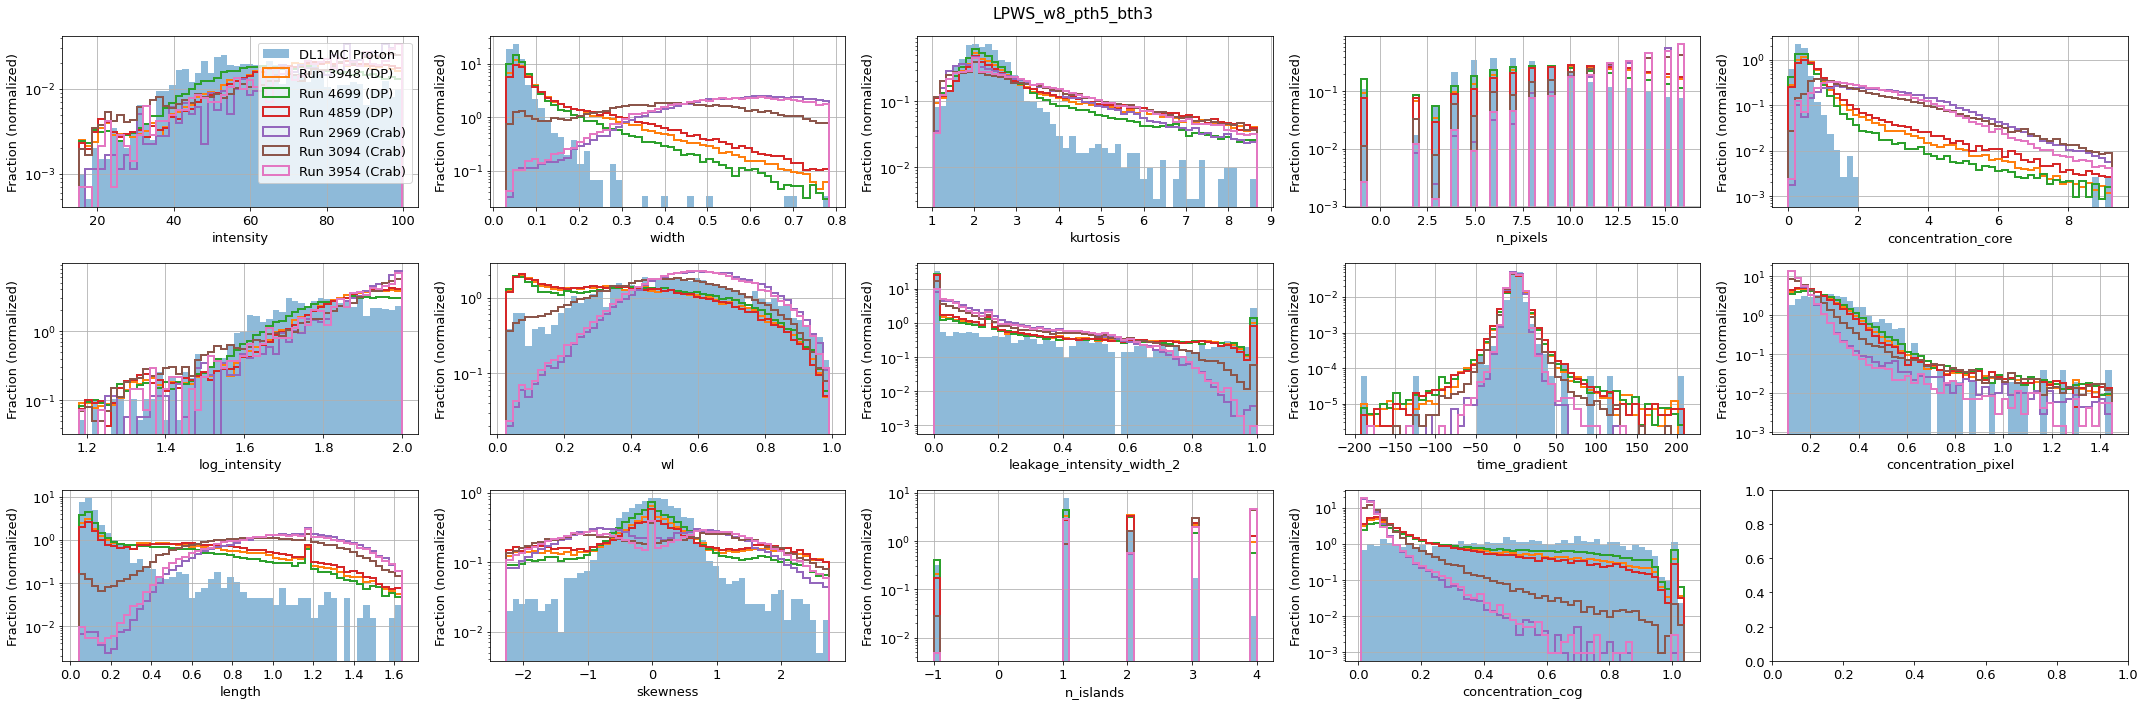

In [57]:
# Intensity cut
INTENSITY_MAX = 100 #100000
INTENSITY_MIN = 0
# Width cut
WIDTH_MIN = 0.03

plots = []
NCOLS = 3
NROWS = ceil(len(HILLASES_OF_INTEREST)/NCOLS)
for j, (lowlevel_config, real_lowlevel_config) in enumerate(zip(lowlevel_configs, real_lowlevel_configs)):
#for j, lowlevel_config in enumerate(lowlevel_configs):
    #plot.append(plt.subplots(len(lowlevel_configs), len(HILLASES_OF_INTEREST), figsize=(10,6**len(HILLASES_OF_INTEREST))))#(6*len(lowlevel_configs), 6*len(HILLASES_OF_INTEREST))))
    plots.append(plt.subplots(NCOLS, NROWS, figsize=(6*NROWS, 10)))#(6*len(lowlevel_configs), 6*len(HILLASES_OF_INTEREST))))
    fig, axes = plots[-1]
    fig.suptitle(lowlevel_config.abbreviation)
    dl1_mc = dl1_data_dict[lowlevel_config] 
    
    #mask_trigger_mc = (np.array(dl1_mc.parameter_value_dict["intensity"])<INTENSITY_MIN) \
    #                + (np.array(dl1_mc.parameter_value_dict["intensity"])>INTENSITY_MAX)

    # Mask MC events
    mcevent_masks = {}
    mcevent_masks["intensity>{imax}".format(imax=INTENSITY_MAX)] = np.array(dl1_mc.parameter_value_dict["intensity"])>INTENSITY_MAX
    mcevent_masks["intensity<={imin}".format(imin=INTENSITY_MIN)] = np.array(dl1_mc.parameter_value_dict["intensity"])<=INTENSITY_MIN
    mcevent_masks["width<={wmin}".format(wmin=WIDTH_MIN)] = np.array(dl1_mc.parameter_value_dict["width"])<=WIDTH_MIN            
    mcmask_sum = np.zeros_like(dl1_mc.parameter_value_dict["intensity"])
    for mask_array in mcevent_masks.values():
        mcmask_sum += mask_array
        
    # Mask real events
    dl1_data = {}
    mask_sum = {}
    for run in real_runs:
        dl1_data[run] = real_dl1_data_dict[real_lowlevel_config][run]         
        event_masks = {}
        for mask_key in [EventType.FLATFIELD, EventType.SKY_PEDESTAL]:
            event_masks[mask_key] = np.array(dl1_data[run].parameter_value_dict["event_type"])==mask_key.value
        event_masks["intensity>{imax}".format(imax=INTENSITY_MAX)] = np.array(dl1_data[run].parameter_value_dict["intensity"])>INTENSITY_MAX
        event_masks["intensity<={imin}".format(imin=INTENSITY_MIN)] = np.array(dl1_data[run].parameter_value_dict["intensity"])<=INTENSITY_MIN
        event_masks["width<={wmin}".format(wmin=WIDTH_MIN)] = np.array(dl1_data[run].parameter_value_dict["width"])<=WIDTH_MIN            
        mask_sum[run] = np.zeros_like(dl1_data[run].parameter_value_dict["event_type"])
        for mask_array in event_masks.values():
            mask_sum[run] += mask_array        
                
    #logger.warning('{0}/{1}'.format(sum(mask_trigger_mc), len(mask_trigger_mc)))    
    for i, param in enumerate(HILLASES_OF_INTEREST):
        # MC
        vals_mc = ma.masked_array(dl1_mc.parameter_value_dict[param], mask=mcmask_sum)
        hist_results = {}
        if not param in hist_results.keys():
            hist_results[param] = axes[i%NCOLS][int(i/NCOLS)].hist(vals_mc, lw=2, bins=50, histtype="stepfilled", alpha=0.5, label=dl1_mc.name, density=True)
        else:
            axes[i%NCOLS][int(i/NCOLS)].hist(vals_mc, lw=2, bins=hist_results[param][1], histtype="stepfilled", alpha=0.5, label=dl1_mc.name, density=True)
        # Real
        for run in real_runs:
            #dl1_data = real_dl1_data_dict[real_lowlevel_config][run]
            
            #mask_trigger = \
            #(np.array(dl1_data.parameter_value_dict["intensity"])<INTENSITY_MIN) \
            #+ (np.array(dl1_data.parameter_value_dict["intensity"])>INTENSITY_MAX) 
            # Mask events
                
            vals = ma.masked_array(dl1_data[run].parameter_value_dict[param], mask=mask_sum[run])
            axes[i%NCOLS][int(i/NCOLS)].hist(vals, lw=2, bins=hist_results[param][1], histtype="step", label='Run {run} ({src})'.format(run=run, src=source_runs[run]), density=True)
        #title = lowlevel_config.abbreviation
        #axes[int(i/NCOLS)][i%NCOLS].set_title(title)
        axes[i%NCOLS][int(i/NCOLS)].grid(True, which='major', axis='both')
        axes[i%NCOLS][int(i/NCOLS)].set_yscale('log')
        #axes[int(i/NCOLS)][i%NCOLS].set_xscale('log')
        #axes[int(i/NCOLS)][i%NCOLS].set_ylim(1e-3, 1)
        #if j==len(lowlevel_configs)-1:
        axes[i%NCOLS][int(i/NCOLS)].set_xlabel(param)
        axes[i%NCOLS][int(i/NCOLS)].set_ylabel('Fraction (normalized)')
        if i==0:
            axes[i%NCOLS][int(i/NCOLS)].legend(loc=0)    
    plt.tight_layout() 
    fig_path = lowlevel_config.product_dir_path / "plots" \
    / '{conf}_Intensity{imin}-{imax}.{ext}'.format(conf=lowlevel_config.name, imin=INTENSITY_MIN, imax=INTENSITY_MAX, ext=".png")
    if not fig_path.parent.is_dir():
        os.makedirs(fig_path.parent)
    fig.savefig(fig_path)